# Motivation

In the previous notebook, we looked at some of the problems of NLP, as well as how to solve them. At the same time, we took fairly simple examples, solved them mainly in one way, and did not bother much about the quality.

It is clear that NLP is not about this. Usually this is a full-fledged large task with a huge number of subtasks, hypotheses, and various tools. Therefore, in this notebook, I want to walk through the structure of the NLP pipeline, as well as go into some key concepts in detail.

# 1 NLP Pipeline

Despite the fact that NLP is a rather specific subfield of Data Science, the pipeline does not differ significantly from any other Machine Learning task. At the same time, there is a fairly large difference in tools and methods, as well as their combinations. Therefore, first we will consider the general pipeline in Machine Learning, then we will move on to NLP, and after that we will compare them with each other.

### 1.1 Classical Machine Learning pipeline

In general, Machine Learning pipeline can be described in several steps:

1) Data acquisition

2) Data pre-processing - handle missing values and outliers

3) Feature engineering - work with features (scale / normalize them), create new and get rid of useless ones

4) Model building

5) Evaluation and choosing the best model - usually we have more than one option to choose from

6) Deployment

7) Monitor and update - we should always monitor the bugs and inaccuracies of the model, and if necessary, correct them in time.

Remember that the structure of the pipeline varies depending on the person and tasks, so only an approximate standard version is displayed here. Now let's see what is the difference between this and NLP pipeline.

### 1.2 NLP pipeline

NLP pipeline has the following structure:

1) Data acquisition

2) Basic pre-processing - spelling correction, discarding irrelevant information, and so on

3) More advanced data processing - sentence and word tokenization, stemming / lemmatization

4) Feature engineering - creating embeddings

5) Model building

6) Model evaluation

7) Deployment

8) Monitor and update.

As we see, the structure does not change much. At the same time, based on the complexity of human language, the NLP pipeline pays much more attention to processing the data we work with. This is not only long, but also very important work, since the quality of the model directly depends on the quality of the data, so these steps should be taken very carefully.

In this notebook we will focus on these parts, as well as on feature engineering. As a result, I want to analyze three topics - how to make text embeddings, how to compare them with each other, and how to process data before we even create those embeddings.

# 2 Text embeddings

### 2.1 Basic operations we can do with texts

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Let's create a sample sentence:

In [5]:
sentence1 = 'A cat atte the CAKES'
sentence1

'A cat atte the CAKES'

**As we see, there are several problems with it:**

1) It is a sentence, but for embeddings we need separate words. Process of dealing with it is called tokenization, and we already covered it previously

2) It contains capital letters, which are not informative and are not needed. This is solved in a standard way

3) It contains useless words, such as 'a' and 'the'. They are not informative, hence, just take space. It is better to remove them. In NLP there is a special name for these type of words - stopwords. So, removing stopwords is a separate process

4) It contains a grammar mistake (atte instead of ate) and a non-standard word form (CAKES instead of CAKE). So, we need to try to map the word to its standard form. In NLP, there are two ways to do it:

4.1) Stemming - we operate on a single word without knowing its context, based on some built-in heuristics. Despite it works fast, it may lead to mistakes (usually, we just remove last few characters from word. Example: cakes -> cake)

4.2) Lemmatization - now we use morphological analysis of words. So, we will be able to map word better to a word good, for example. So, obviously lemmatization is more accurate than stemming. However, it is more time consuming and in practice there might be no significant improvements if we choose lemmatization over stemming, so it is always a trade-off.

Let's solve all these issues one by one with our example. I will use lemmatization, since we do not have much data.

In [6]:
# tokenize sentence
tokenized_sentence = word_tokenize(sentence1)
tokenized_sentence

['A', 'cat', 'atte', 'the', 'CAKES']

In [7]:
# lower words
l_tokenized_sentence = [token.lower() for token in tokenized_sentence]
l_tokenized_sentence

['a', 'cat', 'atte', 'the', 'cakes']

In [8]:
# remove stopwords
stop_words = set(stopwords.words('english'))
filtered_sentence = [token for token in l_tokenized_sentence if token not in stop_words]
filtered_sentence

['cat', 'atte', 'cakes']

In [9]:
# apply lemmatization
lemmatizer = WordNetLemmatizer()
preprocessed_sentence = [lemmatizer.lemmatize(token) for token in filtered_sentence]
preprocessed_sentence

['cat', 'atte', 'cake']

### 2.2 One hot encoding

Note that this section is partially based on a practical NLP book (I will leave a link in the references).

The idea is very simple: we construct a vocabulary of words (which is usually obtained by looking at the sentences in the train sample). After that, we encode each sentence in the following way:

1) create a vector, having the length of a vocabulary

2) loop through each element in the dictionary. If this word is in the sentence (note that it does not matter how many times it occurs) - set 1, if not - set 0.

For example, suppose we have a vocabulary V = ['I', 'he', 'she', 'loves', 'love', 'hates', 'hate', 'sushi', 'pizza']. The order matters, so for these sentences we will have following vector representations:

'I love sushi' -> [1, 0, 0, 0, 1, 0, 0, 1, 0]

'he hates pizza' -> [0, 1, 0, 0, 0, 1, 0, 0, 1]

Now let's code it:

In [10]:
sentences = ['a cat ate the cake',
             'everybody wants to be a superstar',
             'I love science']

In [11]:
def preprocess_text(text):

    tokenized_sentence = word_tokenize(text)
    l_tokenized_sentence = [token.lower() for token in tokenized_sentence]
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [token for token in l_tokenized_sentence if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    preprocessed_sentence = [lemmatizer.lemmatize(token) for token in filtered_sentence]

    return preprocessed_sentence

def create_vocabulary_and_sentences(sentences):
  vocabulary = set()
  preprocessed_sentences = []
  for sentence in sentences:
      preprocessed_sentence = preprocess_text(sentence)
      preprocessed_sentences.append(preprocessed_sentence)
      vocabulary.update(preprocessed_sentence)
  return vocabulary, preprocessed_sentences

def OHE(sentences, vocabulary):
  endoced_sentences = []
  word_to_index = {word: idx for idx, word in enumerate(vocabulary)}
  for sentence in sentences:
    OHE_vector = [1 if word in sentence else 0 for word in vocabulary]
    endoced_sentences.append(OHE_vector)
  return endoced_sentences, word_to_index


In [12]:
vocabulary, preprocessed_sentences = create_vocabulary_and_sentences(sentences)
embeddings, incices = OHE(preprocessed_sentences, vocabulary)
incices

{'superstar': 0,
 'cake': 1,
 'science': 2,
 'love': 3,
 'everybody': 4,
 'want': 5,
 'cat': 6,
 'ate': 7}

In [13]:
embeddings

[[0, 1, 0, 0, 0, 0, 1, 1], [1, 0, 0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0, 0, 0]]

### 2.3 Why OHE is not used?

There are many issues with OHE:

1) Sizes of vectors are proportional to the length of vocabulary. Since vocabularies are usually large, the vectors are large as well. This is a big problem, which results in:

1.1) The curse of dimensionality: as the number of features or dimensions grows, the amount of data we need to generalize accurately grows exponentially (see references). In general case, the larger the dimension of the vector is, the more distant the objects in our feature space become relative to each other. At the same time, they are approximately at the same distance from each other - but still far away

1.2) We consume more memory. In case of big data, it is not wise to spend a lot of memory in cases where we can easily optimize our solution

1.3) It starts to be more complicated to train, as well we create more options for overfitting.

2) Not a fixed-length representations for different texts. In case of a small sentence, the vector will be containing almost all zeros, while in case with big ones there will be much more values of 1

3) We do not capture any context (we operate under the assumption that the words appear in the document independently of each other), as well as semantic things which are essential for natural language

4) In test set we will usually get new words which were absent in the vocabulary. In simples cases, they will be just ignored. However, probably there are smarter ways to deal with it.

Fortunately, we have many more available methods that will help us resolve the issues.

### 2.4 Bag of N-Grams

To capture some context, it is a good idea to look not at particular words, but at chunks of several words. Each chunk is called n-gram and n is a hyperparameter. Suppose we choose n=3 (consider three-grams). In this case the sentence 'I enjoy cookies and I eat them everyday' will consist of following chuncks: array(['and eat', 'and eat them', 'cookies and', 'cookies and eat',
       'eat them', 'eat them everyday', 'enjoy cookies',
       'enjoy cookies and', 'them everyday'], dtype=object).

The special case of Bag of N-Grams is a Bag of Words (BoW), where n=1, so it becomes almost same as OHE. The only difference is that in BoW we count the word occurences. BoW, as well as the general case of Bag of N-Grams, is implemented in sklearn as CountVectorizer. Let's see how it looks like:

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

sentences = ['a cat ate the cake',
             'everybody wants to be a superstar',
             'I love science']

vectorizer = CountVectorizer(ngram_range=(3, 3)) # get bi-grams and three-grams
X = vectorizer.fit_transform(sentences)
vectorizer.get_feature_names_out()

array(['ate the cake', 'cat ate the', 'everybody wants to',
       'to be superstar', 'wants to be'], dtype=object)

In [15]:
print(X.toarray())

[[1 1 0 0 0]
 [0 0 1 1 1]
 [0 0 0 0 0]]


### 2.5 TF-IDF

Although Bag of N-Grams seems to outperform OHE by looking at context and counting the occurences, it is still a weak method. BoW (as well as OHE) tend to treat all words as equally important (it only counts the occurences). To correct this, the TF-IDF method was invented. The intuition is following: if a particular word appears many times in a particular document, but we do not see it frequently in other documents, then it is important for this document. For example, we expect Data Scientists to be good at maths, Python, SQl, Git, and so on. That is why we will see these words frequently in their CVs. However, not many DS people know Assembly or can speak Mandarin. So, probably these words might distinct some people from many other, if we are searching for particular skills.

So, on the one hand we have a TF (term frequency) component - how often a term or a word appears in a given document. On the other hand, we have an IDF (inverse document frequency) component - importance of the term in the whole text. The TF-IDF score is calculated as a product of two components. Mathematically, it can be written like this:

$$TF(t, d) = \frac{\text{# occurences of term t in document d}}{\text{# terms in document d}},$$



$$IDF(t) = log(\frac{\text{# documents in the corpus}}{\text{# documents with term t in them}}),$$

$$\text{TF-IDF score} = TF * IDF.$$

$#$ stands for the number (to keep formulas short).

Now it is time to code it:

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sentences)
vectorizer.get_feature_names_out()

array(['ate', 'be', 'cake', 'cat', 'everybody', 'love', 'science',
       'superstar', 'the', 'to', 'wants'], dtype=object)

In [17]:
print(X.toarray())

[[0.5        0.         0.5        0.5        0.         0.
  0.         0.         0.5        0.         0.        ]
 [0.         0.4472136  0.         0.         0.4472136  0.
  0.         0.4472136  0.         0.4472136  0.4472136 ]
 [0.         0.         0.         0.         0.         0.70710678
  0.70710678 0.         0.         0.         0.        ]]


### 2.6 Drawbacks of basic vectorization approaches

1) Vectors are sparse and high-dimensional, therefore, we want to somehow create vectors of fixed lenghts

2) We are not good at dealing with OOV words (in simplest case we just ignore them)

3) Units are treated as independent units - we cannot capture relationships between words well.

To resolve the issues, we need to switch to more advanced methods and use neural networks.

### 2.7 Word2Vec

Now we take context into account to improve the quality of the model (comparing with previous methods). In Word2Vec, we represent each word as a vector of 32 or more dimesions. In the original paper, there were proposed two methods to solve the problem of capturing the context. Note that I will not dive deep into details (since it seems to me there are already a lot of things in this notebook), but one can check them in the dive into deep learning book (https://d2l.ai/chapter_natural-language-processing-pretraining/word2vec.html). However, I will explain the intuition.

##### 2.7.1 Skip-gram

The idea is that we can generate surrounding of the word given the word. For example, suppose we have a sentence 'A dog ate my NLP homework'. We take the word 'my' as a center, and take a context size of 2. So, we will try to predict words 'dog', 'ate', 'NLP', 'homework' given the word 'my'. We assume independency, therefore, we can multiply this conditional probabilities, and take a log with a minus sign for further minimization (as we usually do with maximum likelihood estimation approach).

##### 2.7.2 Continuous Bag of Words (CBOW)

Now we will do the exact opposite - we will predict a word given its context. So, given words 'dog', 'ate', 'NLP', 'homework' we will try to predict the word 'my'. Again, the result will be the loss function for further minimization (remember that we have multiple documents).

##### 2.7.3 Why it is good?

Word2Vec is probably the oldest way to use neural networks for the purposes of creating sentence embeddings. It was shown that the algorithm can capture dependencies such as:

King - Man + Woman $\approx$ Queen, which seems really good.

This means it is time to use it. We will download a pre-trained Word2Vec model (this is definetely a better idea than to train a model on our small sample). Note that Word2Vec is a model to encode words. To create embeddings of documents, we can take the average of the word embeddings (quite common approach). This section will be based on the following code (https://github.com/PradipNichite/Youtube-Tutorials/blob/main/Yotutube_WordVectors.ipynb).

In [18]:
pip install --upgrade gensim -q

In [19]:
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec

In [20]:
# see the available models
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [21]:
# choose one and download it
wv1 = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [22]:
wv1['apple'] # see how an embedding looks like

array([-0.06445312, -0.16015625, -0.01208496,  0.13476562, -0.22949219,
        0.16210938,  0.3046875 , -0.1796875 , -0.12109375,  0.25390625,
       -0.01428223, -0.06396484, -0.08056641, -0.05688477, -0.19628906,
        0.2890625 , -0.05151367,  0.14257812, -0.10498047, -0.04736328,
       -0.34765625,  0.35742188,  0.265625  ,  0.00188446, -0.01586914,
        0.00195312, -0.35546875,  0.22167969,  0.05761719,  0.15917969,
        0.08691406, -0.0267334 , -0.04785156,  0.23925781, -0.05981445,
        0.0378418 ,  0.17382812, -0.41796875,  0.2890625 ,  0.32617188,
        0.02429199, -0.01647949, -0.06494141, -0.08886719,  0.07666016,
       -0.15136719,  0.05249023, -0.04199219, -0.05419922,  0.00108337,
       -0.20117188,  0.12304688,  0.09228516,  0.10449219, -0.00408936,
       -0.04199219,  0.01409912, -0.02111816, -0.13476562, -0.24316406,
        0.16015625, -0.06689453, -0.08984375, -0.07177734, -0.00595093,
       -0.00482178, -0.00089264, -0.30664062, -0.0625    ,  0.07

In [23]:
# create embeddings for documents
def sent_vec(sent, wv):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in wv:
            ctr += 1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [24]:
sent_vec('We could train Word2Vec but we took an already existing model', wv1) # see how it looks like

array([-0.15669886,  0.09659704, -0.0006841 ,  0.12492879, -0.03975423,
        0.0264945 , -0.10586294, -0.06576538, -0.05833944,  0.02169037,
       -0.04096766, -0.07859802, -0.20018514,  0.03949483, -0.12138875,
        0.09797923,  0.11720435,  0.16860708, -0.01061217,  0.00718085,
       -0.24809265, -0.04015128,  0.12363974,  0.00786686, -0.07455826,
        0.02379954, -0.26138814,  0.0492293 , -0.02235921, -0.03495026,
       -0.02483463,  0.03269211, -0.05508931, -0.13896179, -0.13136037,
        0.08147256, -0.17266782,  0.12187449, -0.0777866 ,  0.08729553,
       -0.02444331, -0.01855469,  0.06997172,  0.08512878,  0.04562644,
       -0.04402379, -0.02343432, -0.17426554, -0.10504913,  0.06116867,
       -0.19106293,  0.22306824, -0.0186793 ,  0.19610596,  0.03684998,
        0.13249207, -0.14419556, -0.10837396, -0.00463486, -0.15522766,
       -0.12607892, -0.0895195 , -0.19709905, -0.06052778, -0.02882353,
       -0.20842552, -0.11843554,  0.12970734, -0.04682922,  0.05

##### 2.7.4 Problems with Word2Vec

1) Regardless of the context, there will always be the same embeddings for the same word (actually, this is why it makes sense to switch to more powerful tools such as BERT and GPT)

2) It does not capture global dependencies, which sometimes might be bad (since we only look at close contexts)

3) Again an issue with out of vocabulary words.

### 2.8 GloVe

This method was invented by researchers from Stanford to resolve one of the issues with Word2Vec - capturing global properties. In a nutshell, in GloVe, we use co-occurence matrix to estimate the conditional probabilities of meeting particular words given the context. See references if you are interested in details. The method for using it will be the same - download pre-trained model using api.

In [25]:
wv2 = api.load('glove-twitter-50')

[==================================================] 100.0% 199.5/199.5MB downloaded


### 2.9 FastText

The key idea is that now we use n-grams - consider subword information when generating word vectors. So, **now we finally can provide embeddings for OOV words**. Also, it is useful for morphologically rich languages.

In [28]:
wv3 = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


### 2.10 Issues with all of previous models and introduction to transformers

Consider the word 'normal' and the following two sentences:

'It is not normal that Jack spends more time with NLP than with his wife. She considers this as cheating.'

'The height distribution of unicorns can be considered normal.'

As we see, the meanings are completely different, but embeddings will be the same. **And this is where transformers are extremely useful**.

However, it is simpler to explain the idea of transformers through the drawbacks of LSTMs and RNNs (see one of my previous project to deeper understand what are RNNs and LSTMs - https://github.com/AlgazinovAleksandr/Time_Series_forecasting/blob/main/TS_H2O_and_LSTM.ipynb).

LSTMs have several problems:

1) they are slow (including due to the fact that the words are passed sequentially)

2) these models are not truly bi-directional.

The concept of self attention used in transformers has proven to perform much better in problems such as text translation. If we take a closer look - we notice that both key components of transformers (encoder and decoder) are sufficient structures to understand the language. Therefore, we can choose just on of them and stack it multiple times - this is where BERT and GPT come from, the models which we will use to create embeddings later.

### 2.11 GPT (generative pre-trained transformer)

Here we stack decoders. The idea is to predict, which word comes next, given a sentence (uni-directional model). In order to apply it, we will use Hugging Face library and pre-trained GPT2 model, which is available there. Note that now we will not be able to create embeddings in a simple way as we did before, since we need to do tensor operations. That is why, we will use PyTorch for that reasons.

In [31]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.4 MB/s eta 0:00:00


In [59]:
from transformers import GPT2Tokenizer, GPT2Model
import torch
def embeddings_with_LLMs(model, documents):
  embeddings = []
  for document in documents:
      input_ids = torch.tensor([tokenizer.encode(document)])
      with torch.no_grad():
          output = model(input_ids)
      sentence_embedding = output.last_hidden_state.mean(dim=1).numpy()
      embeddings.append(sentence_embedding)
  return embeddings

In [33]:
documents = [
    "This is an example sentence.",
    "Another sentence to embed.",
    "GPT-2 is a powerful language model."
]
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
GPT = GPT2Model.from_pretrained(model_name)
embeddings = embeddings_with_LLMs(GPT, documents)

### 2.12 BERT (bi-directional encoder representations from transformers)

Here we stack encoders to solve the following problems on the pre-training stage (more about it - later):

1) Masked language models (MLM) - understand which words are missing in the sentences

2) Next sentence prediction (NSP) - binary classification which will help us understand, whether the second sentence is likely to come after first one, or not.

In [64]:
from transformers import BertTokenizer, BertModel
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
BERT = BertModel.from_pretrained(model_name)
embeddings = embeddings_with_LLMs(BERT, documents)

### 2.13 GPT vs BERT

Both of them have a pre-training stage - we have a lot of unlabeled data to train on. At this stage, we learn the basic structure of language and text, find common patterns, and so on. After that, BERT uses fine-tuning (the only thing we do is change inputs and output layers to train the model to solve new tasks) on a small labeled dataset (separate process for each problem we consider). This allows the model to efficiently learn new things (actually, there are many types of BERT which are working well with particular problems and particular types of texts and languages). However, there are some issues with fine-tuning:

1) We still need much data

2) We can easily overfit

3) We train the model not the way people learn to do things.

That is why, as I understand (be careful since there is not too much information and I might be mistaken), GPT focuses more on RL rather than on fine-tuning. It also uses zero-shot, one-shot, or few-shots learning. Here the idea is that we provide model with additional information or even examples to help it train better.

Another difference is that BERT (created by Google) is bi-directional and uses encoder stacking, while GPT (created by OpenAI) is unidirectional and uses decoder stacking.

### 2.14 Summary

Remember the drawbacks of the OHE method. Let me briefly remind some of the methods we studied, as well as ways they helped us overcome these drawbacks. Firstly, OHE cannot handle OOV words. This issue was resolved using FastText approach. Moreover, we understand that words are not equally important. This is where TF-IDF is useful. Finally, we want to make sure that embeddings change with the change of contexts, even if the words are similar. At that point we switch to the most powerful models - LLMs (large language models).

# 3 Similarities between vectors

Alright, now we know how to convert texts into vectors. Now it is time to figure out how to measure, whether the vectors (hence, the texts) are similar, or not.

### 3.1 Jaccard Similarity

It is defined as the size of the intersection divided by the size of the union of two sets:

$$J(A, B) = \frac{|A \cap B|}{|A \cup B|}.$$

Although it is simple and intuitive, it seem to be applicable only to OHE and BoW. The problem is that it can only be used on binary representations. In the case of most embeddings, we are dealing with real vectors with continuous values.

### 3.2 Cosine similarity

We already came across it:

$$\text{cosine similarity}(A, B) = \frac{\sum_{i=1}^nA_iB_i}{\|A\|_2 \cdot \|B\|_2}.$$

It is probably the most used way to calculate similarities. The problem is that last time we got similarities, which are very high and very close to each other. In my practice, I have already seen this problem before, so I cannot call cosine similarity the best and universal method. Despite that, we will still use it in this problem.

### 3.3 Minkowski metric

$$d_{\text{Minkowski}}(P, Q) = \left( \sum_{i=1}^{n} |p_i - q_i|^p \right)^{\frac{1}{p}}.$$

if $p = 2$, this becomes the Euclidean distance, and if $p = 1$, this is the Manhattan distance. Personally, I prefer these metrics, since they usually do not lead to the same problems as cosine similarity, and they are very popular in general. To convert them to similarities, we can use the following formula:

$$sim_{\text{Minkowski}} = \frac{1}{1 + d_{\text{Minkowski}}}.$$

**All in all, since Jaccard Similarity is not applicable to our problem, and we have already tried both cosine and Euclidean distances, I believe the problem was with embeddings, and we need another approach. So, let's try almost all the methods to solve the initial problem. We will use cosine similarity, despite the fact I find Euclidean a better one.**

# 4 Try to solve the problem from the previous notebook better

I recently read a post in which one person said that if you ask beginners what method of building embeddings to use, almost everyone will answer BERT with complete confidence. At the same time, in some situations, the classic TF-IDF may work better. I propose to use different methods to solve our problem from the last notebook, meaningfully interpreting the results and comparing the models with each other. Note that this time we will only use pre-trained neural networks, not trying to make it on our own (as we did last time).

In [50]:
documents = ["Data Scientist with three years of experience. Good knowledge of NLP and Time Series. Have a specialized education and basic knowledge of MLOps, as well as a love for board games. Also interested in research and write articles for scientific journals.",
    "Experienced Data Scientist proficient in NLP and Time Series. Skilled in MLOps and passionate about board games. Love writing articles for scientific journals and conducting research.",
    "Data Scientist with a strong background in NLP and Time Series. Possess specialized education and extensive experience in MLOps. Enjoys playing board games and loves contributing to scientific journals.",
    "Seeking a Data Scientist role with three years of experience in NLP and Time Series. Excels in MLOps and has a keen interest in board games and scientific research.",
    "Software Engineer with expertise in Computer Vision and Machine Learning. Knowledgeable in Natural Language Processing and Time Series analysis. Enjoys playing board games during leisure time.",
    "AI Researcher with a focus on Reinforcement Learning and Deep Learning. Interested in exploring NLP techniques and Time Series forecasting. Enjoys participating in board game competitions.",
    "Data Analyst with skills in Data Visualization and Statistical Analysis. Looking to learn more about NLP and Time Series. Enjoys leisure time playing board games with friends.",
    "Marketing Specialist with a passion for consumer behavior analysis. Proficient in social media campaigns and content creation. Enjoys reading books on psychology and writing travel blogs.",
    "Environmental Scientist dedicated to researching climate change impacts. Specialized in GIS and remote sensing. Enjoys hiking and birdwatching during weekends.",
    "Financial Analyst with expertise in risk assessment and portfolio management. Skilled in financial modeling and data analysis. Enjoys watching documentaries on history and ancient civilizations.",
    "We are the champions, my friends And we'll keep on fighting till the end We are the champions We are the champions No time for losers Cause we are the champions of the World",
    "Never gonna give you up Never gonna let you down Never gonna run around and desert you Never gonna make you cry Never gonna say goodbye Never gonna tell a lie and hurt you",
    "Yeah if you read this it was a Rick Roll"]

def preprocess_text(text):

    tokenized_sentence = word_tokenize(text)
    l_tokenized_sentence = [token.lower() for token in tokenized_sentence]
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [token for token in l_tokenized_sentence if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    preprocessed_sentence = [lemmatizer.lemmatize(token) for token in filtered_sentence]
    return ' '.join(preprocessed_sentence)

documents = [preprocess_text(document) for document in documents]
documents

['data scientist three year experience . good knowledge nlp time series . specialized education basic knowledge mlops , well love board game . also interested research write article scientific journal .',
 'experienced data scientist proficient nlp time series . skilled mlops passionate board game . love writing article scientific journal conducting research .',
 'data scientist strong background nlp time series . posse specialized education extensive experience mlops . enjoys playing board game love contributing scientific journal .',
 'seeking data scientist role three year experience nlp time series . excels mlops keen interest board game scientific research .',
 'software engineer expertise computer vision machine learning . knowledgeable natural language processing time series analysis . enjoys playing board game leisure time .',
 'ai researcher focus reinforcement learning deep learning . interested exploring nlp technique time series forecasting . enjoys participating board game

In [51]:
vectorizer = CountVectorizer(ngram_range=(2, 3)) # get bi-grams and three-grams
embeddings = vectorizer.fit_transform(documents)
embeddings = embeddings.toarray()
embeddings

array([[0, 0, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [52]:
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

def plot_similarity_matrix(similarity_matrix, documents):
    labels = [doc.split()[0] + "..." for doc in documents]
    plt.gcf().set_size_inches(16, 9)
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap="cividis")
    plt.title("Similarity Matrix")
    plt.xlabel("Docs")
    plt.ylabel("Docs")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

def calculate_cosine_similarity(embeddings):
    similarity_matrix = cosine_similarity(embeddings)
    return similarity_matrix

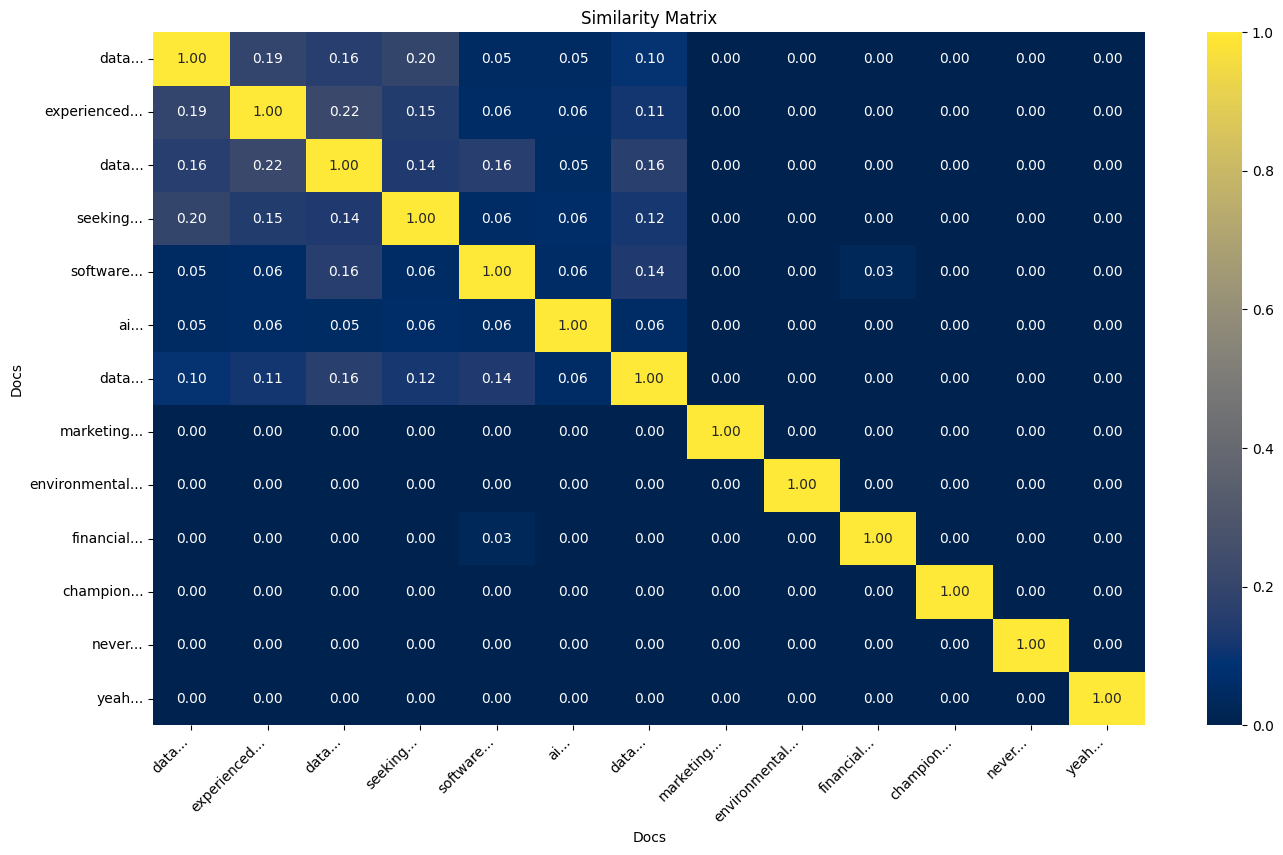

In [53]:
# Bag on N-Grams
similarity_matrix = calculate_cosine_similarity(embeddings)
plot_similarity_matrix(similarity_matrix, documents)

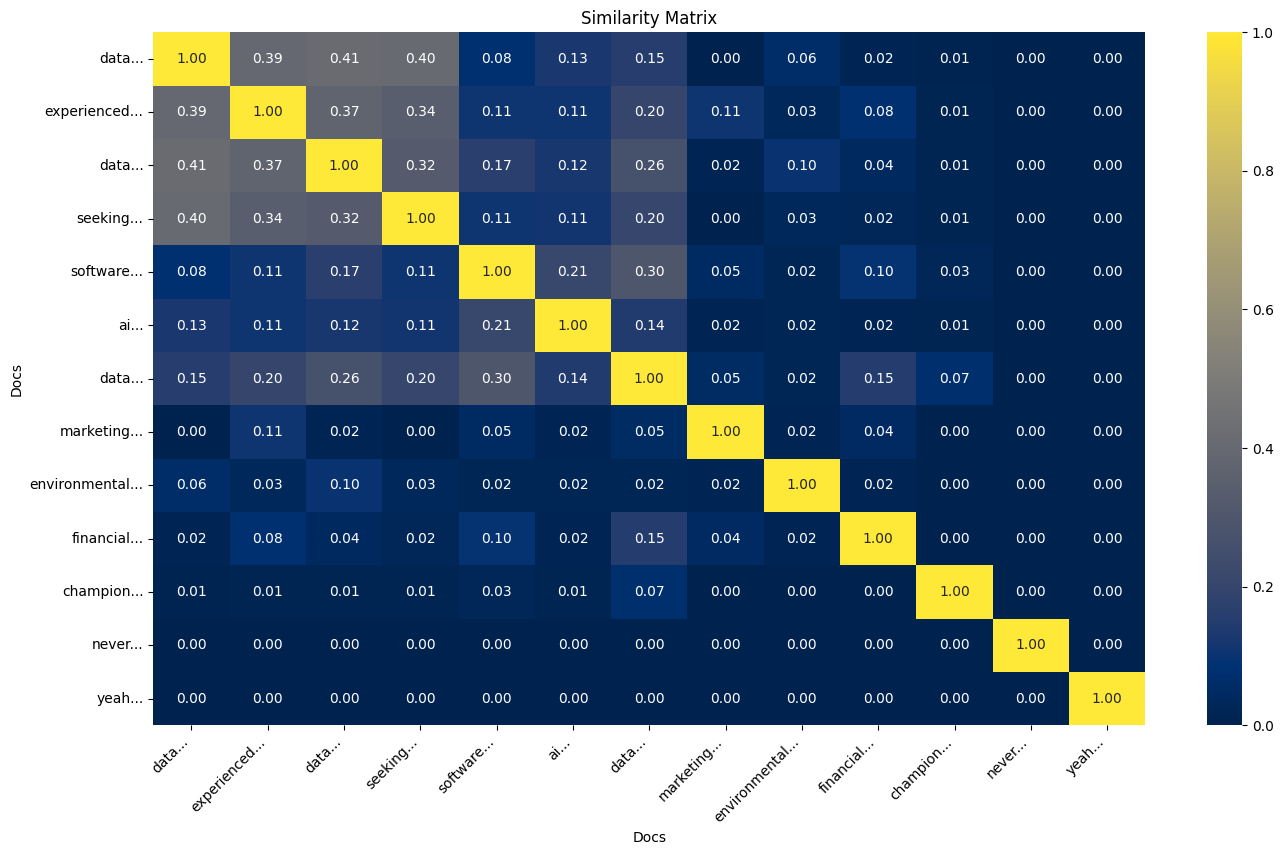

In [54]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
embeddings = vectorizer.fit_transform(documents)
embeddings = embeddings.toarray()
similarity_matrix = calculate_cosine_similarity(embeddings)
plot_similarity_matrix(similarity_matrix, documents)

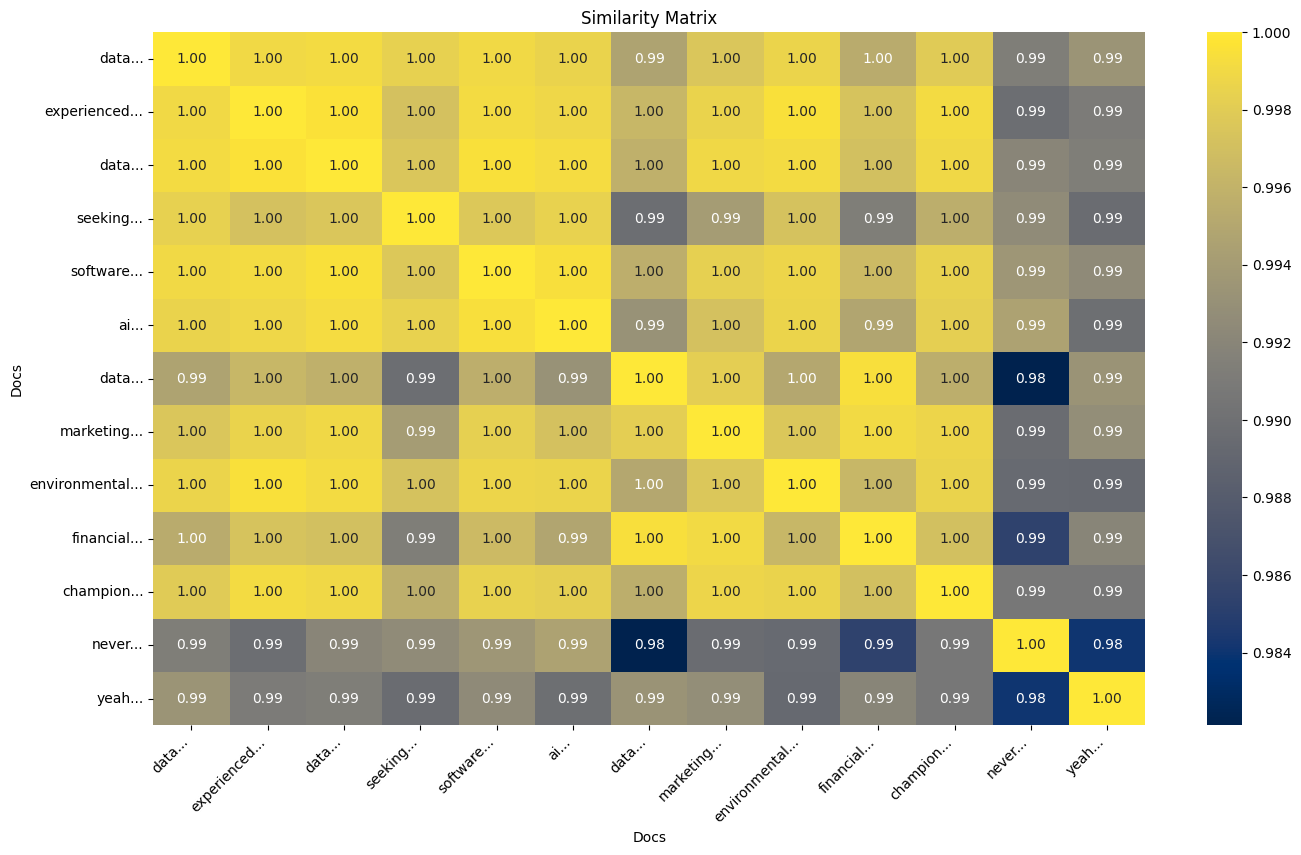

In [63]:
# GloVe
embeddings = [sent_vec(document, wv2) for document in documents]
similarity_matrix = calculate_cosine_similarity(embeddings)
plot_similarity_matrix(similarity_matrix, documents)

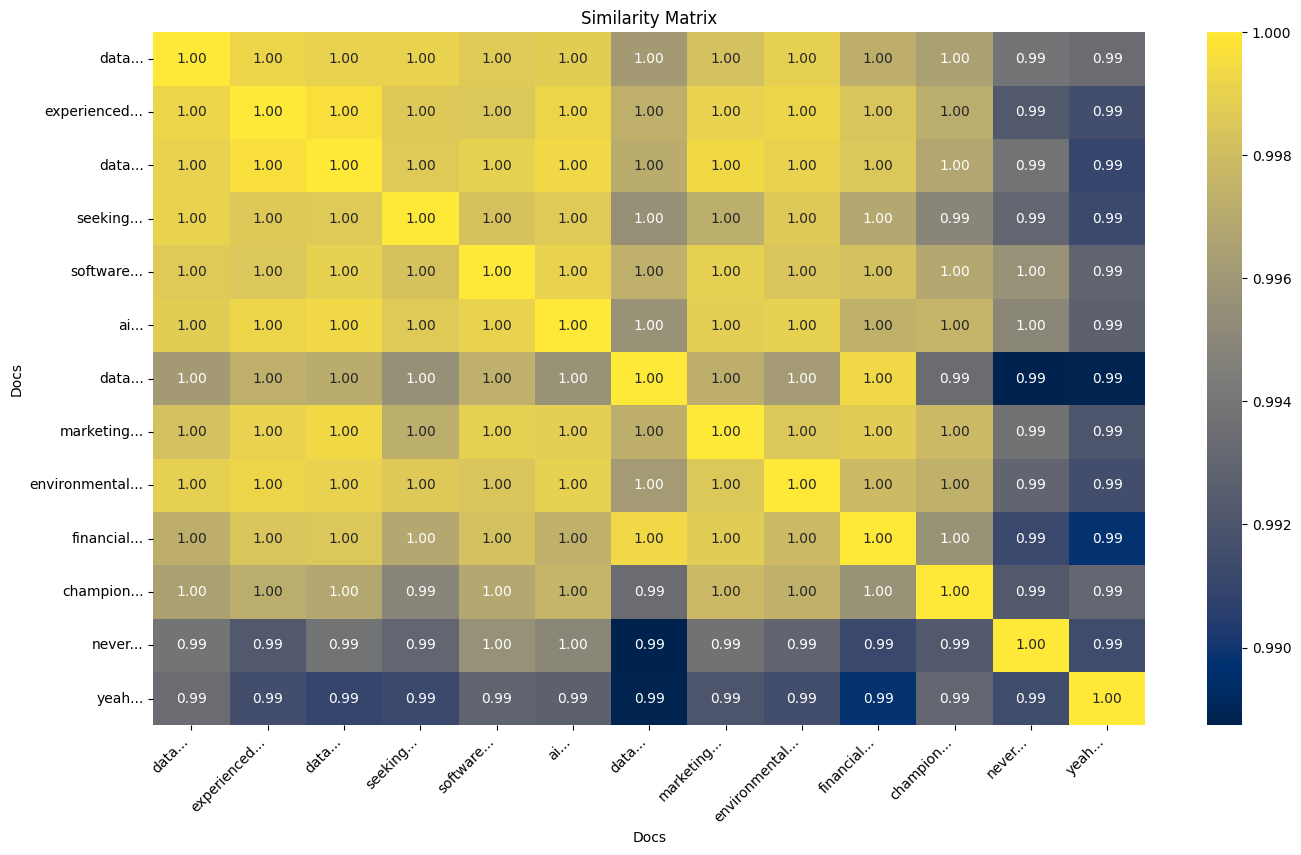

In [62]:
# FastText
embeddings = [sent_vec(document, wv3) for document in documents]
similarity_matrix = calculate_cosine_similarity(embeddings)
plot_similarity_matrix(similarity_matrix, documents)

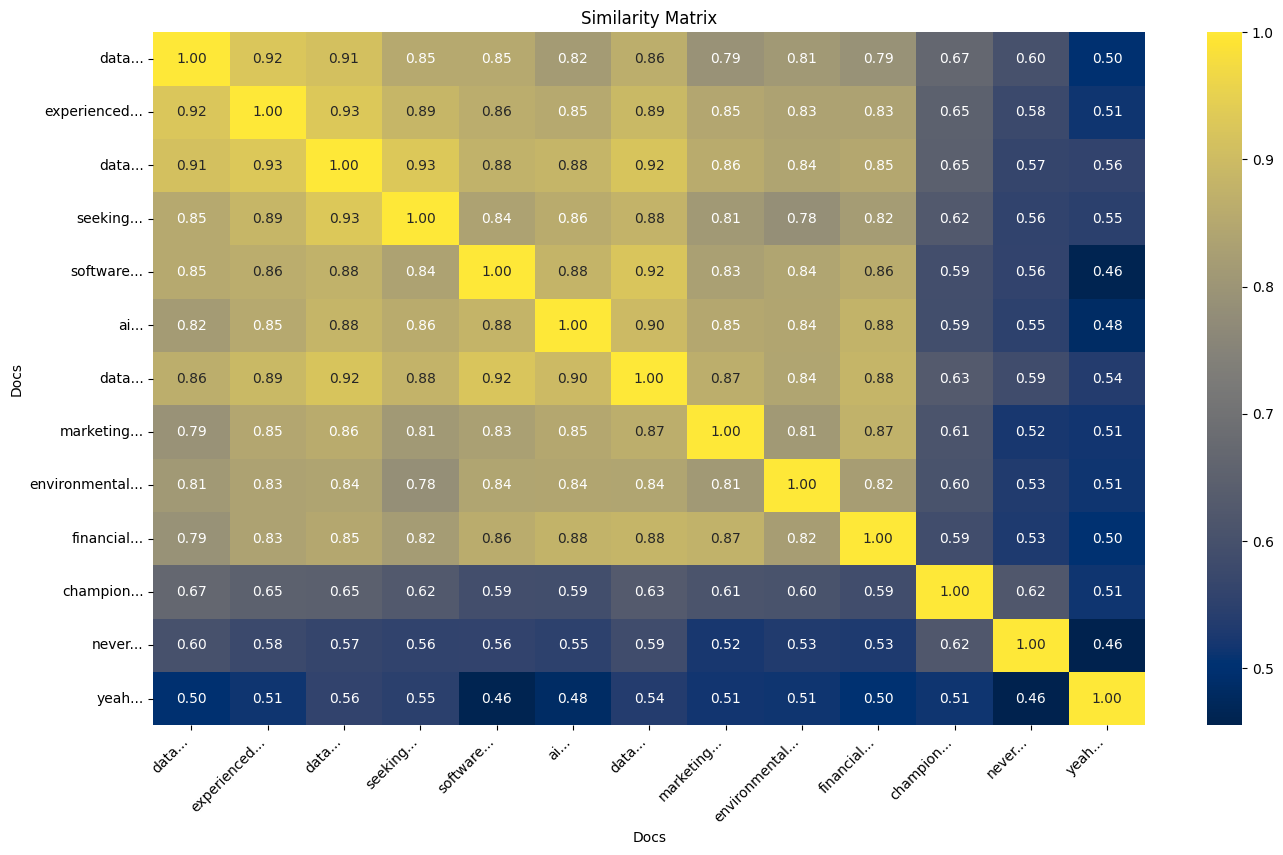

In [60]:
# BERT
embeddings = embeddings_with_LLMs(BERT, documents)
embeddings = np.vstack(embeddings)
similarity_matrix = calculate_cosine_similarity(embeddings)
plot_similarity_matrix(similarity_matrix, documents)

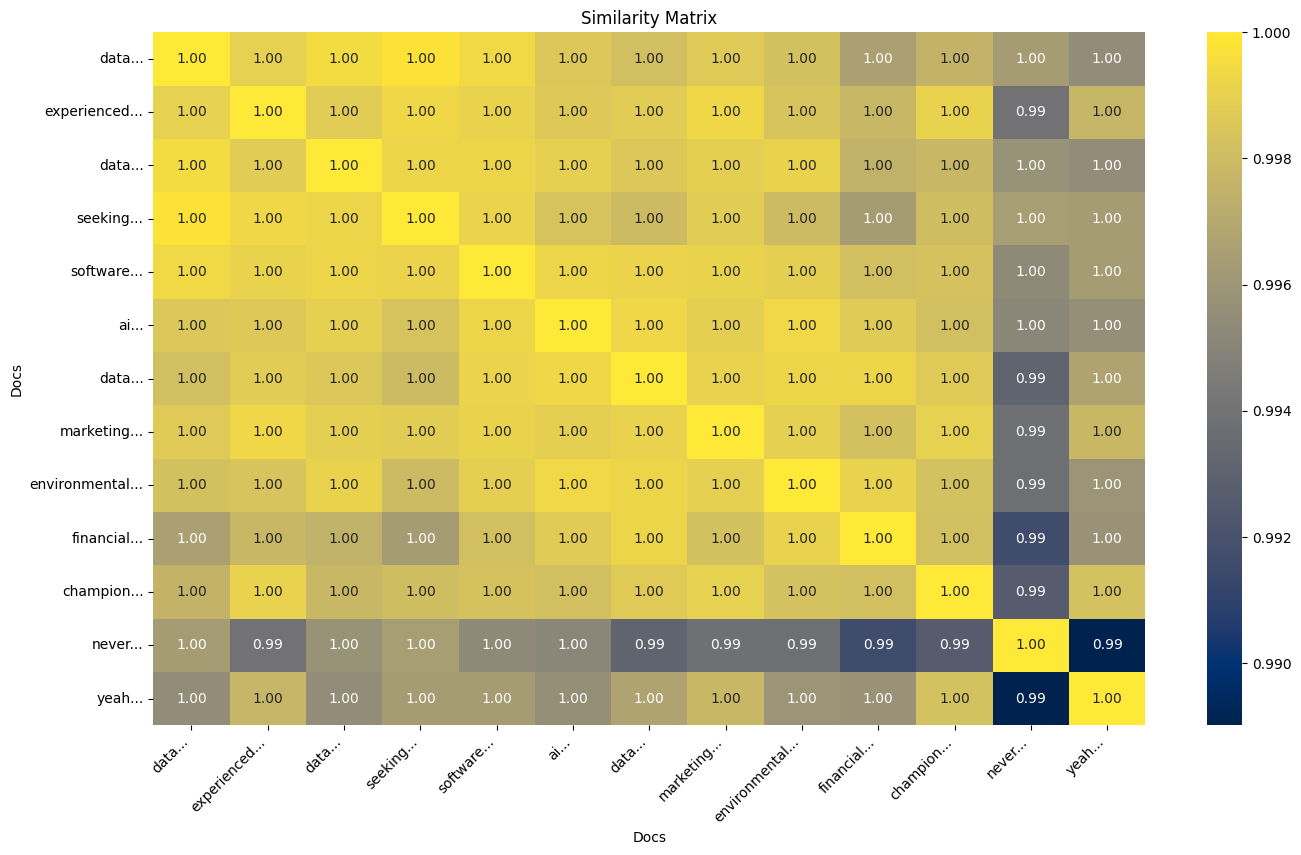

In [61]:
# GPT
embeddings = embeddings_with_LLMs(GPT, documents)
embeddings = np.vstack(embeddings)
similarity_matrix = calculate_cosine_similarity(embeddings)
plot_similarity_matrix(similarity_matrix, documents)

# 5 Conclusions

BERT and TF-IDF turn out to be the best algorithms for the problem, yet still far from ideal. Firstly, I do not want almost all vectors to be very close to 1 (that is why GPT, FastText, and GloVe do not give good results for this problem). Secondly, I do not want all values to be very close to 0 (this is where Bag of N-Grams messed up).

If we compare TF-IDF with BERT, I believe BERT worked better. On the one hand, sentences that are really similar to the initial one turned out to look more similar (at least on average) than the other ones. On the other hand, three sentences which were generated for fun turned out not to be similar to other ones (it means that the model understands what it is doing).

So, it looks like we managed to improve the performance, compared to the previous notebook. At the same time, we looked at the key concepts and models in NLP. Despite this file turned out to be longer that I expected, I am sure we have done a great job.

# References:

1) https://builtin.com/machine-learning/lemmatization# - Stemming and Lematization

2) https://www.amazon.com/Practical-Natural-Language-Processing-Pragmatic/dp/1492054054 - Practical NLP book

3) https://en.wikipedia.org/wiki/Curse_of_dimensionality - About curse of dimensionality

4) https://d2l.ai/chapter_natural-language-processing-pretraining/word2vec.html - About Word2Vec

5) https://github.com/PradipNichite/Youtube-Tutorials/blob/main/Yotutube_WordVectors.ipynb - Download a pre-trained Word2Vec and use it to create embeddings

6) https://huggingface.co/ - About transformers

7) https://nlp.stanford.edu/projects/glove/ - About GloVe

8) https://github.com/AlgazinovAleksandr/Time_Series_forecasting/blob/main/TS_H2O_and_LSTM.ipynb - One of my previous projects

9) https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf - About transformers